In [1]:
import numpy as np
from numpy import linalg as la
import numpy.random as rd
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import pickle

MU = 3.986*10**5#地球重力定数[km^3/s^2]

g = 9.81 #重力加速度[m/s^2]
R_earth = 6378 #地球の半径[km]
SCALE_HEIGHT = 8.432#スケールハイト[km]
RHO_0 = 1.225#標準大気密度[kg/m^3]
H_reEntry = 120 #大気圏高度[km]
M_earth = 5.9724*10**24

#機体によるので、あとで
A = np.pi#ハヤブサよりちょい大きめ[kg]
Rn = 2 #てきとー

#なんかを参照
Cd = 1.6
Cl = 0.8
DT = 0.1#刻み

In [2]:
def dominant_eq(D,L,gamma,v,r, M):
    gamma_rad = np.deg2rad(gamma)
    dot_r = v*np.sin(gamma_rad)
    dot_v = -D/M*10**3-g*np.sin(gamma_rad)*10**(-3)
    dotgamma_rad = L/(M*v)*10**3-g*np.cos(gamma_rad)/v*10**(-3)+v*np.cos(gamma_rad)/r
    dot_gamma = np.rad2deg(dotgamma_rad)
    return dot_r,dot_v,dot_gamma


def get_precise_density(z, random=False):
    matrix = np.array([[0.000000,-3.322622E-6,9.111460E-4,-0.2609971,5.944694],
                       [0.000000,2.873405E-5,-0.008492037,0.6541179,-23.62010],
                       [-1.240774E-5,0.005162063,-0.8048342,55.55996,-1443.338],
                       [0.00000,-8.854164E-05,0.03373254,-4.390837,176.5294],
                       [3.661771E-7,-2.154344E-4,0.04809214,-4.884744,172.3597],
                       [1.906032E-8,-1.527799E-5,0.004724294,-0.6992340,20.50921],
                       [1.199282E-9,-1.451051E-6,6.910474E-4,-0.1736220,-5.321644],
                       [1.140564E-10,-2.130756E-7,1.570762E-4,-0.07029296,-12.89844],
                       [8.105631E-12,-2.358417E-9,-2.635110E-6,-0.01562608,-20.02246],                    
                       [-3.701195E-12,-8.608611E-9,5.118829E-5,-0.06600998,-6.137674]])
    Zs = np.array([z**4,z**3,z**2,z**1,1])
    if z>750:
        i = 9
        rho = np.exp(Zs@matrix[i])
    elif z>500:
        i = 8
        rho = np.exp(Zs@matrix[i])    
    elif z>300:
        i = 7
        rho = np.exp(Zs@matrix[i])    
    elif z>200:
        i = 6
        rho = np.exp(Zs@matrix[i])   
    elif z>150:
        i = 5
        rho = np.exp(Zs@matrix[i])    
    elif z>120:
        i = 4
        rho = np.exp(Zs@matrix[i])        
    elif z>110:
        i = 3
        rho = np.exp(Zs@matrix[i])    
    elif z>100:
        i = 2
        rho = np.exp(Zs@matrix[i])        
    elif z>91:
        i = 1
        rho = np.exp(Zs@matrix[i])        
    elif z>86:
        i = 0
        rho = np.exp(Zs@matrix[i])
    else:
        rho = RHO_0*np.exp(-z/SCALE_HEIGHT)
    
    if random:
        sigma = 0.05
        err = rd.normal(0, 0.05)
        rho = rho*(1+err)
    else:
        pass
    return rho

def get_Drag_Lift(v,rho, S=A, Cd=Cd, Cl=Cl):
    D = 1/2*rho*v**2*S*Cd
    L = 1/2*rho*v**2*S*Cl
    return D,L

def f(h, v, gamma, M, S=A, Cd=Cd, Cl=Cl, random=True):
    rho = get_precise_density(h, random=True)
    D,  L = get_Drag_Lift(v, rho, S, Cd=Cd, Cl=Cl)
    r = h + R_earth
    dot_r, dot_v, dot_gamma = dominant_eq(D, L, gamma, v, r, M)
    return np.array([dot_r, dot_v, dot_gamma])

def get_heating_rate(density, v, Rn=Rn):
    """対流加熱と輻射過熱を考える
    Arg:
    density[kg/m^3] 大気密度
    v[km/s] 物体の速度
    Rn[m] ノーズ半径
    
    Return:
    q_conv[MW/m^2] 対流加熱率
    q_rad[MW/m^2] 輻射加熱率
    """
    v *= 10**3
    q_conv = 1.35*10**(-8)*np.sqrt(density/Rn)*v**3.04*10 #[kW/m^2]
    q_conv *= 10**(-3) #[MW/m^2]
    
    if Rn <= 1:
        a = 1.072*10**6*v**(-1.88)*density**(-0.325)
    elif 1< Rn <=2:
        a = min([0.6, 1.072*10**6*v**(-1.88)*density**(-0.325)])
    else:
        a = min([0.5, 1.072*10**6*v**(-1.88)*density**(-0.325)])
    
    f_v = 0
    V_lst = [9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11500]
    f_lst = [1.5, 4.3, 9.7, 19.5, 35, 55, 81, 115, 151, 238, 359]
    
    i = 0
    while v > V_lst[i+1]:
        i += 1
    
    if v>9000:
        f_v = (f_lst[i+1]-f_lst[i])*(v-V_lst[i])/(V_lst[i+1]-V_lst[i])+f_lst[i]
        if f_v <0:
            print("っむむむむ")
    q_rad = 4.736*10**2*Rn**a*density**1.22*f_v
    return q_conv, q_rad
    
def re_entry(v_reEntry,gamma_reEntry, M, dt=DT):
    h = H_reEntry
    v = v_reEntry
    gamma = gamma_reEntry
    rho = get_precise_density(h)
    q_conv, q_rad = get_heating_rate(rho, v)
    t = 0
    t_lst = [t]
    h_lst = [h]
    v_lst = [v]
    gamma_lst= [gamma]
    q_conv_lst, q_rad_lst = [q_conv], [q_rad]
    while 0 <= h <= H_reEntry:
        k1_vector = f(h, v, gamma,M)*DT
        k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
        k1_h = k1_r
        
        k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2, M)*DT
        k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
        k2_h = k2_r

        k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2, M)*DT
        k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
        k3_h = k3_r

        k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma, M)*DT
        k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
        k4_h = k4_r

        delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
        delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
        delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
        ####################################
        h += delta_r_euqual_h
        v += delta_v
        gamma += delta_gamma
        t += DT
        heating_rate = get_heating_rate(get_precise_density(h), v)
        t_lst.append(t)
        h_lst.append(h)
        v_lst.append(v)
        gamma_lst.append(gamma)
        q_conv_lst.append(heating_rate[0])
        q_rad_lst.append(heating_rate[1])
    if h_lst[-1] >= H_reEntry:
        #大気に弾かれた場合
        print(h_lst[-1])

    else:
        #print("カプセル帰還")
        pass
    return t_lst, h_lst, v_lst, gamma_lst, q_conv_lst, q_rad_lst

In [3]:
class Capsule:
    def __init__(self, mass, S_capsule, Rn=Rn, orbital_height_phase2=25000):
        self.mass = mass
        self.S_capsule = S_capsule
        self.S_after_membrane = S_capsule
        self.Rn = Rn
        
        #フェーズ２
        self.semi_major_axis = R_earth+orbital_height_phase2
        self.v_phase2 = np.sqrt(MU/self.semi_major_axis)
        
        
    def re_entry_simu(self, v_entry, gamma_entry, membrane_parachute_height=20, dt=DT, Cd=Cd, Cl=Cl, random=True):
        h = H_reEntry
        v = v_entry
        gamma = gamma_entry
        rho = get_precise_density(h, random=True)
        q_conv, q_rad = get_heating_rate(rho, v)
        t = 0
        t_lst = [t]
        h_lst = [h]
        v_lst = [v]
        accel_lst = [0.]
        gamma_lst= [gamma]
        q_conv_lst, q_rad_lst = [q_conv], [q_rad]
        ###################################################################################
        ##るんげくった
        while 0 <= h <= H_reEntry:
            if membrane_parachute_height <= h:
                #パラシュート展開せず
                k1_vector = f(h, v, gamma,M=self.mass, S=self.S_capsule)*dt
                k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
                k1_h = k1_r
        
                k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2, M=self.mass, S=self.S_capsule)*dt
                k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
                k2_h = k2_r

                k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2, M=self.mass, S=self.S_capsule)*dt
                k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
                k3_h = k3_r

                k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma, M=self.mass, S=self.S_capsule)*dt
                k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
                k4_h = k4_r

                delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
                delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
                delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
            
            else:
                k1_vector = f(h, v, gamma,M=self.mass, S=self.S_after_membrane)*dt
                k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
                k1_h = k1_r
        
                k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2, M=self.mass, S=self.S_after_membrane)*dt
                k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
                k2_h = k2_r

                k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2, M=self.mass, S=self.S_after_membrane)*dt
                k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
                k3_h = k3_r

                k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma, M=self.mass, S=self.S_after_membrane)*dt
                k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
                k4_h = k4_r

                delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
                delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
                delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
            
            ####################################
            accel = delta_v/dt*10**3/g #G換算
            h += delta_r_euqual_h
            v += delta_v
            gamma += delta_gamma
            t += dt
            heating_rate = get_heating_rate(get_precise_density(h), v)
            t_lst.append(t)
            h_lst.append(h)
            accel_lst.append(accel)
            v_lst.append(v)
            gamma_lst.append(gamma)
            q_conv_lst.append(heating_rate[0])
            q_rad_lst.append(heating_rate[1])
        if h_lst[-1] >= H_reEntry:
            #大気に弾かれた場合
            print(h_lst[-1])
            

        else:
            #print("カプセル帰還")
            pass
        return t_lst, h_lst, accel_lst, v_lst, gamma_lst, q_conv_lst, q_rad_lst
    
    def decision_v_return_apo(self, atmosphere_height=120.):
        """大気に入るためのアポジの最大速度推算
            要するにこれより小さければ戻ってこれる
        Arg:
            atmosphere_height[km] 大気高度 default 200
        Return:
            max_v_apo[km/s] 最大速度
        """
        r_p = atmosphere_height + R_earth
        max_v_apo = np.sqrt(2*MU*(1./self.semi_major_axis-1./(self.semi_major_axis+r_p)))
        return max_v_apo
    
    def get_entry_state(self, v_trans_apo, atmosphere_height=120.):
        r_e = atmosphere_height + R_earth
        v_entry = np.sqrt(v_trans_apo**2 + 2*MU*(1/r_e-1/self.semi_major_axis))
        fpa_entry = np.rad2deg(-np.arccos(v_trans_apo*self.semi_major_axis/v_entry/r_e))
        return v_entry, fpa_entry
    
    def get_time_to_atomosphere(self, v_trans_apo, atmosphere_height=120.):
        r_a = self.semi_major_axis
        h = v_trans_apo*r_a
        energy = 1./2*v_trans_apo**2-MU/r_a
        l = h**2/MU
        e = np.sqrt(1+2*energy*h**2/MU**2)
        r_e = atmosphere_height + R_earth
        theta_e = np.arccos(1./e*(l/r_e-1))
        v_e = np.sqrt(v_trans_apo**2 + 2*MU*(1/r_e-1/self.semi_major_axis))
        fpa_e = -np.arccos(v_trans_apo*self.semi_major_axis/v_e/r_e)
    
        a = (r_a+r_e)/2.
        
        t_atom_to_peri = np.sqrt(a**3/MU)*(2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(theta_e/2))-(e*np.sqrt(1-e**2)*np.sin(theta_e))/(1+e*np.cos(theta_e)))
        t_apo_to_peri = np.pi*np.sqrt(a**3/MU) 
        t_apo_to_atom = t_apo_to_peri-t_atom_to_peri
        return t_apo_to_atom
    
    def drop_point_simu(self, alpha, beta, delta_v=1.56, atmosphere_height=120., Cd=Cd, Cl=Cl):
        """落下地点の誤差円を頑張って描くプログラム
        Arg:
        alpha[deg] 速度ベクトルとの誤差角をΔvベクトルとのなす面を
              軌道面に対して垂直(つまり最大誤差となるように)とったときの誤差角
        delta_v[km/s] 減速量
        atmoshphere_height[km] 大気高度
        """
        alpha = np.deg2rad(alpha) #[rad]
        beta = np.deg2rad(beta) #[rad]
        ra = self.semi_major_axis # 軌道遠地点(phase2での長半径
        v1 = self.v_phase2 #減速前の速さ
        v1_vector = np.array([v1,0,0])
        re = atmosphere_height+R_earth
        
        v2_vector = np.array([v1-delta_v*np.cos(alpha)*np.cos(beta), delta_v*np.cos(alpha)*np.sin(beta), delta_v*np.sin(alpha)])
        v2_norm = la.norm(v2_vector)
        cosi = np.dot(v1_vector, v2_vector)/(v1*v2_norm)
        i = np.arccos(cosi)
        if alpha <= 0:
            i = -i
        else:
            pass
        
        h = la.norm(np.array([-ra*(v1-delta_v*np.cos(alpha)*np.cos(beta)), ra*delta_v*np.sin(alpha), 0]))# 角運動量
        
        energy = 1./2.*v2_norm**2 - MU/ra #比エネルギー
        l = h**2/MU
        e = np.sqrt(1+2*energy*h**2/MU**2) #離心率
        
        #大気圏面での状態
        theta_e = np.arccos(1./e*(1-l/re)) # [rad]
        print("大気突入までのダウンレンジ:{}[deg]".format(np.rad2deg(theta_e)))
        ve = np.sqrt(2*(energy+MU/re))
        fpa_e = - np.arccos(h/re/ve)
        fpa_e = np.rad2deg(fpa_e)
        
        #大気圏内の飛行
        t_atm_lst, h_atm_lst, accel_atm_lst, v_atm_lst, gamma_atm_lst, _, _ = self.re_entry_simu(ve, fpa_e, membrane_parachute_height=0, dt=DT)
        
        #ダウンレンジの取得
        down_range = 0
        for j in range(len(t_atm_lst)):
            down_range += v_atm_lst[j]*np.cos(np.deg2rad(gamma_atm_lst[j]))
        
        delta_theta = down_range/R_earth #[rad]
        print("大気圏突入後のダウンレンジ:{}".format(np.rad2deg(delta_theta)))
        
        theta_d = np.rad2deg(theta_e+delta_theta)#longtitude
        
        phi_d = np.rad2deg(i * np.sin(np.deg2rad(theta_d)))
        
        return phi_d, theta_d

In [4]:
capsule1 = Capsule(mass=714.87, S_capsule=A)
print(capsule1.v_phase2)

3.5641503650365927


### 落下地点の推測
#### 誤差としていれるもの
1. 位置誤差3$\sigma$
2. 大気モデル誤差3$\sigma$
3. 高度30kmから風の影響（仮に）

大気突入までのダウンレンジ:140.54665051947146[deg]
大気圏突入後のダウンレンジ:113.61581633683558
大気突入までのダウンレンジ:140.53638958738145[deg]
大気圏突入後のダウンレンジ:113.58498329576487
大気突入までのダウンレンジ:140.52721103712386[deg]
大気圏突入後のダウンレンジ:113.31888980888762
大気突入までのダウンレンジ:140.51911410621025[deg]
大気圏突入後のダウンレンジ:113.20131743112222
大気突入までのダウンレンジ:140.51209812259194[deg]
大気圏突入後のダウンレンジ:113.33523461832544
大気突入までのダウンレンジ:140.50616250438472[deg]
大気圏突入後のダウンレンジ:113.3508124748951
大気突入までのダウンレンジ:140.50130675962845[deg]
大気圏突入後のダウンレンジ:113.18394839986438
大気突入までのダウンレンジ:140.4975304860847[deg]
大気圏突入後のダウンレンジ:113.15733321209481
大気突入までのダウンレンジ:140.49483337107284[deg]
大気圏突入後のダウンレンジ:113.23462274366922
大気突入までのダウンレンジ:140.49321519134097[deg]
大気圏突入後のダウンレンジ:113.29499473823735
大気突入までのダウンレンジ:140.4926758129744[deg]
大気圏突入後のダウンレンジ:113.22593034217108
大気突入までのダウンレンジ:140.49321519134097[deg]
大気圏突入後のダウンレンジ:113.36588950063059
大気突入までのダウンレンジ:140.49483337107284[deg]
大気圏突入後のダウンレンジ:113.25154853094246
大気突入までのダウンレンジ:140.4975304860847[deg]
大気圏突入後のダウンレンジ:113.24047937458649
大気突入までのダウン

[]

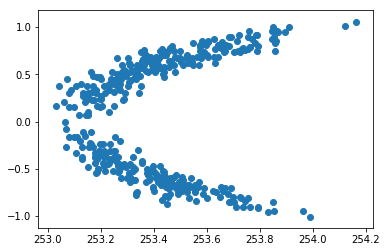

In [9]:
"""
phi_d_lst, theta_d_lst = [], []
alpha_lst = np.arange(-1, 1, 0.1)
beta_lst = np.arange(-1, 1, 0.1)
for alpha in alpha_lst:
    for beta in beta_lst:
        phi_d, theta_d = capsule1.drop_point_simu(alpha, beta)
        phi_d_lst.append(phi_d)
        theta_d_lst.append(theta_d)
plt.scatter(theta_d_lst, phi_d_lst)
plt.plot()
"""

In [6]:
capsule1 = Capsule(mass=714.87, S_capsule=np.pi)
print(capsule1.v_phase2)

3.5641503650365927


大気突入までのダウンレンジ:140.3944352546784[deg]
大気圏突入後のダウンレンジ:112.69169867817513
かかった時間:787.5000000001105[s]
最大減速G:41.39300076515787[G]
最大よどみ点加熱率:3.537247372660615[MW/m^2]
熱負荷:68.93192531002545[MJ/m^2]


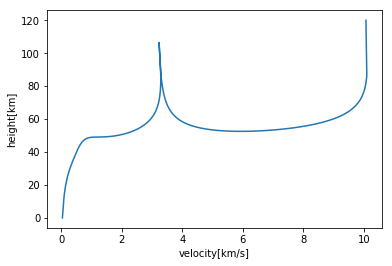

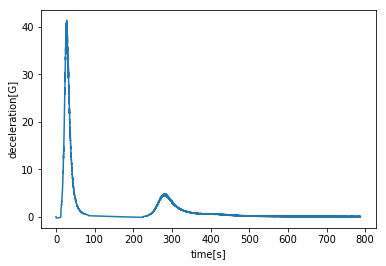

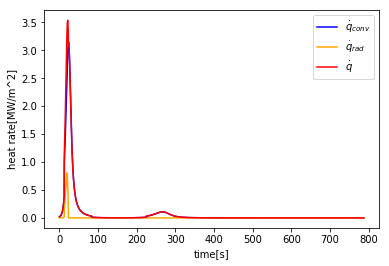

In [8]:
deltav = 1.56
v_trans_apo =  capsule1.v_phase2 - deltav
capsule1.get_time_to_atomosphere(v_trans_apo)
capsule1.drop_point_simu(0, 0)


v_entry, fpa_entry = capsule1.get_entry_state(v_trans_apo)
t_lst, h_lst, accel_lst, v_lst, gamma_lst, q_conv_lst, q_rad_lst = capsule1.re_entry_simu(v_entry, fpa_entry)
print("かかった時間:{}[s]".format(t_lst[-1]))
print("最大減速G:{}[G]".format(-min(accel_lst)))
#よどみ点加熱
heat_rate = []
heat_load = 0
for i in range(len(t_lst)-1):
    q_sum = q_conv_lst[i]+q_rad_lst[i]
    heat_rate.append(q_sum)
    heat_load += q_sum*DT
    
print("最大よどみ点加熱率:{}[MW/m^2]".format(max(heat_rate)))
print("熱負荷:{}[MJ/m^2]".format(heat_load))
#v-h図プロット
plt.plot(v_lst, h_lst)
plt.xlabel("velocity[km/s]")
plt.ylabel("height[km]")
#plt.savefig("../output/final_v-h.png")
plt.show()

decel_lst = [-i for i in accel_lst]
plt.plot(t_lst, decel_lst)
plt.xlabel("time[s]")
plt.ylabel("deceleration[G]")
#plt.savefig("../output/deceleration.png")
plt.show()

plt.plot(t_lst, q_conv_lst, label="$\dot{q}_{conv}$", color="blue")
plt.plot(t_lst, q_rad_lst, label="$\dot{q}_{rad}$", color="orange")
plt.plot(t_lst[:-1], heat_rate, label="$\dot{q}$", color="red")
plt.xlabel("time[s]")
plt.ylabel("heat rate[MW/m^2]")
plt.legend()
#plt.savefig("../output/final_heat_rate.png")
plt.show()


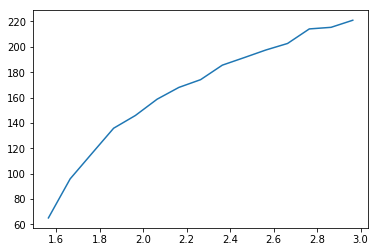

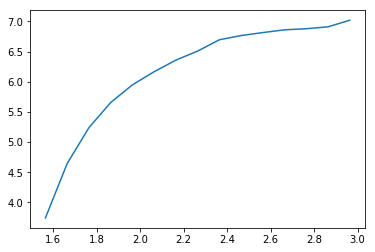

In [75]:
deccelation_lst = []
q_max_lst = []
delta_v_lst = []
for i in range(len(v_return_apo_lst)):
    delta_v = capsule1.v_phase2 - v_return_apo_lst[i]
    v_entry, fpa_entry = capsule1.get_entry_state(v_return_apo_lst[i])
    _,_,accel_lst,v_lst,_,q_conv_lst,q_rad_lst = capsule1.re_entry_simu(v_entry, fpa_entry)
    deccelation_lst.append(-min(accel_lst))#G
    q_lst = []
    for j in range(len(q_conv_lst)):
        q_lst.append(q_conv_lst[j]+q_rad_lst[i])
    q_max = max(q_lst)
    delta_v_lst.append(delta_v)
    q_max_lst.append(q_max)
plt.plot(delta_v_lst, deccelation_lst)
plt.show()

plt.plot(delta_v_lst, q_max_lst)
plt.show()

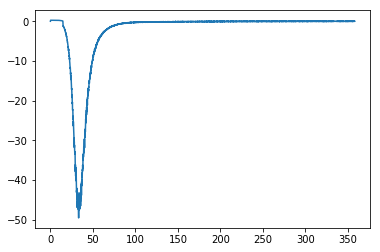

着地速度:48.09209303206771[m/s]


In [35]:
t_lst,_,accel_lst,v_lst,_,_,_ = capsule1.re_entry_simu(v_entry=9.0, gamma_entry=-15.)
plt.plot(t_lst, accel_lst)
plt.show()
print("着地速度:{}[m/s]".format(v_lst[-1]*10**3))

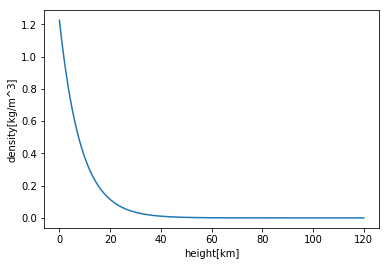

In [36]:
# 大気のプロット
h_lst = np.arange(0, 120, 0.01)
rho_lst =[]
for h in h_lst:
    rho = get_precise_density(h)
    rho_lst.append(rho)
plt.plot(h_lst, rho_lst)
plt.xlabel("height[km]")
plt.ylabel("density[kg/m^3]")
plt.savefig("../output/density-height.png")
plt.show()